# Acoustics Analysis

- Vowel analytics

---
- 2021-04-14: first created
    - [x] Plot vowel spaces (points, ellipses, quadrilateral) per speaker/rate
    - [-] Calculate vowel-space/vowel area
- 2021-04-22
    - Run F1, F2 stats

In [4]:
# Basic
import os
import re
import pickle
import numpy as np
import pandas as pd
from glob import glob
from tqdm import tqdm

# Visualization
from IPython.display import Image, HTML, display
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager
import seaborn as sns
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual

# Custom
from tools.utils import *
from tools.plots import *
from tools.postproc import *
from tools.guided_pca import GuidedPCA

rand_seed = 0

## Settings

In [5]:
# --- Settings
save_again = True
use_mel = True
drop_f0 = True # f0 column was dropped because f0 tracking failed for many cases (N>5000).

# --- Directories
data_raw_dir = 'data'
data_proc_dir = 'data_processed'
data_plot_dir = 'data_plots'
stat_dir = 'stats'

data_file = os.path.join(data_proc_dir, 'data_2021-04-13.csv') # <----- UPDATE HERE

# --- Parameters
spkr_list = ['F01','F02','F03','F04','M01','M02','M03','M04']
vowel_list = ['IY1', 'IH1', 'EH1', 'AO1', 'AH1', 'AA1', 'AE1', 'UH1', 'UW1']
rate_list = ['N','F']
acous_col = ['F1', 'F2']
artic_col = ['TRx','TRz','TBx','TBz','TTx','TTz','JAWx','JAWz','ULx','ULz','LLx','LLz']
if use_mel:
    acous_col = [c + '_mel' for c in acous_col]
acous_col_norm = [re.sub('_mel', '_norm', ac) for ac in acous_col]
artic_col_norm = [ac+'_norm' for ac in artic_col]
pre_phone_poa = ['bilabial','alveolar','velar']
post_phone_poa = ['bilabial','alveolar','velar']

custom_vowels = ['IY1','IH1','EH1','AE1','AA1','UW1']
num_points = 9
vowel_mid_point = 0.5 # 0~1
corner_vowels = ['IY1', 'AE1', 'AA1', 'UW1']
vowel_label = ['i', 'ɪ', 'ɛ', 'ʌ', 'ɔ', 'ɑ', 'æ', 'ʊ', 'u']

vowel2ipa = {
    'IY1': 'i',
    'IH1': 'ɪ',
    'EH1': 'ɛ',
    'AO1': 'ʌ',
    'AH1': 'ɔ',
    'AA1': 'ɑ',
    'AE1': 'æ',
    'UH1': 'ʊ',
    'UW1': 'u',
}
num_pca = 3
pca_col = ['PC1','PC2','PC3']
const_list = ['P','B','T','D','S','K','G','HH']
poa_list = ['bilabial','alveolar','velar','fricative']

# --- Font
# fontpath = '/home/zzandore/.local/share/fonts/Times New Roman 400.ttf'
# prop = font_manager.FontProperties(fname=fontpath)
# matplotlib.rcParams['font.family'] = prop.get_name()
print('Loaded')

Loaded


In [6]:
# Set style (globally)
# sns.set_style("whitegrid", {'font.family' : 'serif' , 'font.serif' : 'Times New Roman'})
# plt.style.use(['science','ieee','no-latex']) # <-- this generates too HIGH quality pics

In [7]:
# Prepare data
D = pd.read_csv(data_file)
D.tail(3)

,Token,FileID,Speaker,Block,Rate,Sent,Rep,Word,PreVowel,Vowel,...,JAWz_norm,ULx_norm,ULz_norm,LLx_norm,LLz_norm,PreVowelPOA,PostVowelPOA,Pronunciation,Tag,PlaceOfArticulation
138572,52079,M04_B12_S60_R01_N,M04,12,N,S60,1,COME,K,AH1,...,-0.062283,0.127111,0.047193,0.040988,-0.027688,velar,sp,K-AH1-M,C-V1-C,velar-tongue-bilabial
138573,52079,M04_B12_S60_R01_N,M04,12,N,S60,1,COME,K,AH1,...,-0.035660,0.105324,-0.037390,0.069666,0.076274,velar,sp,K-AH1-M,C-V1-C,velar-tongue-bilabial
138574,52079,M04_B12_S60_R01_N,M04,12,N,S60,1,COME,K,AH1,...,0.032341,0.138669,-0.149052,0.134113,0.268623,velar,sp,K-AH1-M,C-V1-C,velar-tongue-bilabial


In [8]:
# Load palate
pal_files = sorted(glob(os.path.join(data_raw_dir, '*.pkl')))
pal_all = load_palate(pal_files, spkr_list)
print("Loaded")

Loaded


In [9]:
# Load data parameters
with open(os.path.join(data_proc_dir, 'zscore.pkl'), 'rb') as pckl:
    Z = pickle.load(pckl)
with open(os.path.join(data_proc_dir, 'pca.pkl'), 'rb') as pckl:
    PC = pickle.load(pckl)
VT = pd.read_csv(os.path.join(data_proc_dir, 'vowel_targets.csv'))
GM = pd.read_csv(os.path.join(data_proc_dir, 'grand_means.csv'))
time_list = D.TimeAt.unique().tolist()
print('Loaded')

Loaded


<h2 style="background-color: yellow;color:black">Vowel plots</h2>

In [116]:
# Define helper functions
def _plot_dur_vowels(df, which_spkr, which_time, custom_vowels, use_serif=False):
    if use_serif:
        sns.set_style(
            "whitegrid", {'font.family': 'serif', 'font.serif': 'Times New Roman'})

    fig, (ax1, ax2, ax3) = plt.subplots(
        1, 3, figsize=(18, 5), facecolor='white')
    ax1 = plot_duration(ax1, df, which_spkr, custom_vowels, vowel2ipa)
    ax2 = plot_F1F2_df(ax2, df.loc[(df.Speaker == which_spkr) & (df.Rate == 'N') & (df.TimeAt == which_time)],
                       vowel_col='Vowel', vowel_list=custom_vowels,
                       F1_col='F1_mel', F2_col='F2_mel', vowel2ipa=vowel2ipa)
    ax3 = plot_F1F2_df(ax3, df.loc[(df.Speaker == which_spkr) & (df.Rate == 'F') & (df.TimeAt == which_time)],
                       vowel_col='Vowel', vowel_list=custom_vowels,
                       F1_col='F1_mel', F2_col='F2_mel', vowel2ipa=vowel2ipa)
    # Titles
    ax1.set_title('Duration', fontsize=25)
    ax2.set_title('Normal rate', fontsize=25)
    ax3.set_title('Fast rate', fontsize=25)
    if use_serif:
        sns.set_style(
            "whitegrid", {'font.family': 'serif', 'font.serif': 'Times New Roman'})
    fig.suptitle(f'Speaker: {which_spkr}', y=0.9)
    fig.tight_layout()
    return fig, [ax1, ax2, ax3]


def _plot_dur_vowel_spaces(df, which_spkr, which_time, custom_vowels,
                           center_stat='median',
                           show_title=True,
                           ax2_title='Vowel space (ellipses)',
                           ax3_title='Vowel space (quadrilateral)',
                           use_serif=False):
    if use_serif:
        sns.set_style(
            "whitegrid", {'font.family': 'serif', 'font.serif': 'Times New Roman'})

    fig, (ax1, ax2, ax3) = plt.subplots(
        1, 3, figsize=(18, 5), facecolor='white')
    # --- Duration plot
    ax1 = plot_duration(
        ax1, df.loc[df.Speaker == which_spkr], which_spkr, custom_vowels, vowel2ipa)
    # --- Ellipse plot
    ax2, params_N = plot_F1F2_df(ax2, df.loc[(df.Speaker == which_spkr) & (df.Rate == 'N') & (df.TimeAt == which_time)],
                                 vowel_col='Vowel', vowel_list=custom_vowels,
                                 F1_col='F1_mel', F2_col='F2_mel', vowel2ipa=vowel2ipa,
                                 center_only=False,
                                 ellipse_only=True,
                                 ellipse_linestyle='-',
                                 return_params=True,
                                 )
    ax2, params_F = plot_F1F2_df(ax2, df.loc[(df.Speaker == which_spkr) & (df.Rate == 'F') & (df.TimeAt == which_time)],
                                 vowel_col='Vowel', vowel_list=custom_vowels,
                                 F1_col='F1_mel', F2_col='F2_mel', show_label=False,
                                 center_only=False,
                                 ellipse_only=True,
                                 ellipse_linestyle='--',
                                 return_params=True,
                                 )
    # Prettify
    l1, = ax2.plot([], [], 'k-', linewidth=2)
    l2, = ax2.plot([], [], 'k--', linewidth=2)
    ax2.legend([l1, l2], ['N', 'F'], fontsize=10)

    # --- Line plot
    ax3 = plot_F1F2_df(ax3, df.loc[(df.Speaker == which_spkr) & (df.Rate == 'N') & (df.TimeAt == which_time)],
                       vowel_col='Vowel', vowel_list=custom_vowels,
                       F1_col='F1_mel', F2_col='F2_mel', vowel2ipa=vowel2ipa,
                       center_only=center_stat,
                       connected_linestyle='-',
                       )
    ax3 = plot_F1F2_df(ax3, df.loc[(df.Speaker == which_spkr) & (df.Rate == 'F') & (df.TimeAt == which_time)],
                       vowel_col='Vowel', vowel_list=custom_vowels,
                       F1_col='F1_mel', F2_col='F2_mel', show_label=False,
                       center_only=center_stat,
                       connected_linestyle='--',
                       )
    # Prettify
    l1, = ax3.plot([], [], 'k-', linewidth=2)
    l2, = ax3.plot([], [], 'k--', linewidth=2)
    ax3.legend([l1, l2], ['N', 'F'], fontsize=10)

    # Titles
    ax1.set_title('Duration', fontsize=25, y=1.02)
    ax2.set_title(ax2_title, fontsize=25, y=1.02)
    ax3.set_title(ax3_title, fontsize=25, y=1.02)

    if show_title:
        if use_serif:
            sns.set_style(
                "whitegrid", {'font.family': 'serif', 'font.serif': 'Times New Roman'})
        fig.suptitle(f'Speaker: {which_spkr}', y=0.9)
    fig.tight_layout()
    return fig, [ax1, ax2, ax3], params_N, params_F

In [122]:
# Plot overall duration and formant patterns for checking
which_time = 0.5
# which_vowels = corner_vowels
which_vowels = custom_vowels

params = {spkr:{} for spkr in spkr_list}
for which_spkr in tqdm(spkr_list, total=len(spkr_list)):
    spkr_dir = os.path.join(data_plot_dir, which_spkr, 'vowel_space')
    safe_mkdir(spkr_dir)

    # Vowel data-point plots (data points with ellipses)
    fig, arr = _plot_dur_vowels(D, which_spkr, which_time, which_vowels, use_serif=True)
    if save_again:
        fig.savefig(os.path.join(spkr_dir, f'{which_spkr}_vowel_data_{len(which_vowels)}.png'), bbox_inches='tight')
    plt.close()

    # Vowel space plots (ellipses, quadri-laterals)
    fig, arr, params_N, params_F = _plot_dur_vowel_spaces(D, which_spkr, which_time, which_vowels, use_serif=True)
    if save_again:
        fig.savefig(os.path.join(spkr_dir, f'{which_spkr}_vowel_space_{len(which_vowels)}.png'), bbox_inches='tight')
    plt.close()

    # Update
    params[which_spkr]['normal'] = params_N
    params[which_spkr]['fast'] = params_F
print('Done')

100%|██████████| 8/8 [00:12<00:00,  1.57s/it]

Done


interactive(children=(Dropdown(description='which_spkr', options=('F01', 'F02', 'F03', 'F04', 'M01', 'M02', 'M…

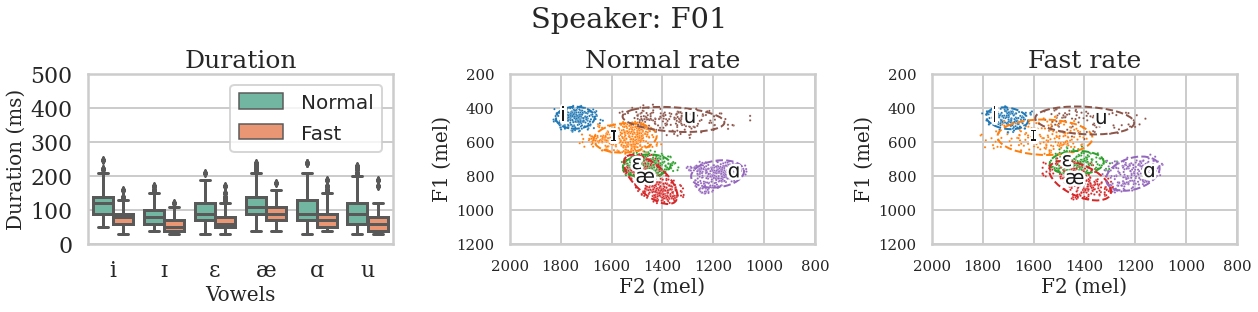

In [123]:
def func1(which_spkr):
    return Image(filename=os.path.join(data_plot_dir, which_spkr, 'vowel_space', 
                                       #f'{which_spkr}_vowel_data_7.png'), 
                                       f'{which_spkr}_vowel_data_6.png'), 
                 width=1000)

spkr_dropdown = widgets.Dropdown(options=spkr_list, value='F01')
interact(func1, which_spkr=spkr_dropdown);
func1('F01')

interactive(children=(Dropdown(description='which_spkr', options=('F01', 'F02', 'F03', 'F04', 'M01', 'M02', 'M…

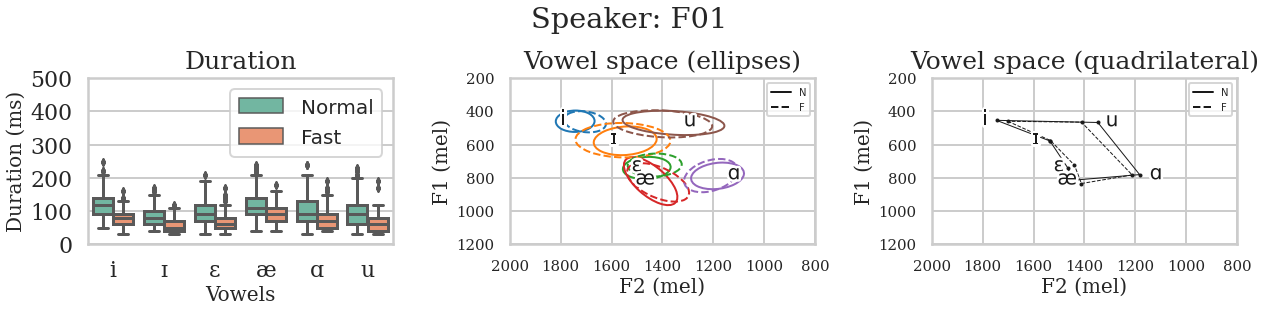

In [124]:
def func2(which_spkr):
    return Image(filename=os.path.join(data_plot_dir, which_spkr, 'vowel_space', 
                                       #f'{which_spkr}_vowel_space_4.png'), 
                                       f'{which_spkr}_vowel_space_6.png'), 
                 width=1000)

spkr_dropdown = widgets.Dropdown(options=spkr_list, value='F01')
interact(func2, which_spkr=spkr_dropdown);
func2('F01')

100%|██████████| 8/8 [00:03<00:00,  2.53it/s]


Done


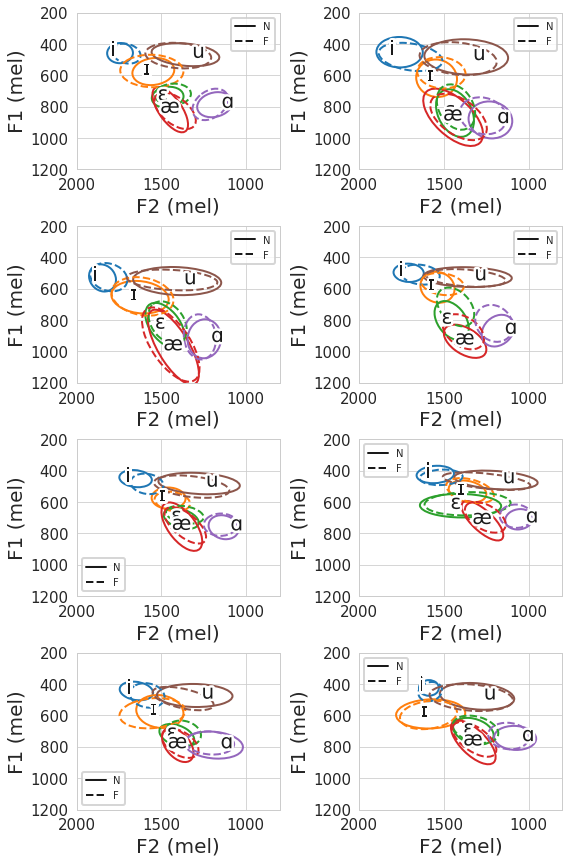

In [134]:
# Make 4x2 plots just for vowel spaces

which_time = 0.5
# which_vowels = corner_vowels
which_vowels = custom_vowels

fig, arr = plt.subplots(4, 2, facecolor='white', figsize=(8, 12))
# spkr_order = ['F01','M01','F02','M02','F03','M03','F04','M04']


for which_spkr, ax in tqdm(zip(spkr_list, arr.flatten()), total=len(spkr_list)):
    spkr_dir = os.path.join(data_plot_dir, which_spkr, 'vowel_space')

    with sns.plotting_context('poster', font_scale=0.8):
        sns.set_style("whitegrid",
                      {'font.family': 'serif', 'font.serif': 'Times New Roman'})
        # --- Ellipse plot
        ax, _ = plot_F1F2_df(ax, D.loc[(D.Speaker == which_spkr) & (D.Rate == 'N') & (D.TimeAt == which_time)],
                             vowel_col='Vowel', vowel_list=custom_vowels,
                             F1_col='F1_mel', F2_col='F2_mel', vowel2ipa=vowel2ipa,
                             center_only=False,
                             ellipse_only=True,
                             ellipse_linestyle='-',
                             return_params=True,
                             sns_context='poster',
                             )
        ax, _ = plot_F1F2_df(ax, D.loc[(D.Speaker == which_spkr) & (D.Rate == 'F') & (D.TimeAt == which_time)],
                             vowel_col='Vowel', vowel_list=custom_vowels,
                             F1_col='F1_mel', F2_col='F2_mel', show_label=False,
                             center_only=False,
                             ellipse_only=True,
                             ellipse_linestyle='--',
                             return_params=True,
                             sns_context='poster',
                             )
        # Prettify
        l1, = ax.plot([], [], 'k-', linewidth=2)
        l2, = ax.plot([], [], 'k--', linewidth=2)
        ax.legend([l1, l2], ['N', 'F'], fontsize=10)

fig.tight_layout()
print('Done')

<h2 style="background-color:yellow;color:black">Vowel areas (space; within)</h2>

### Calculate vowel areas
- vowel space itself
- individual vowels

#### (1) Individual vowel areas

In [11]:
# Calculate individual vowel space area per vowel/speaker/rate
VA = pd.DataFrame(columns=['Speaker','Rate','Vowel','VowelArea','SpaceArea'], 
                  index=range(len(spkr_list)*len(rate_list)*len(custom_vowels)))

i = 0
for which_spkr in spkr_list:
    F1_mu = Z[which_spkr]['acous']['mean']['F1_mel']
    F1_sd = Z[which_spkr]['acous']['std']['F1_mel']
    F2_mu = Z[which_spkr]['acous']['mean']['F2_mel']
    F2_sd = Z[which_spkr]['acous']['std']['F2_mel']

    for which_rate in ['normal', 'fast']:
        rate = 'F' if which_rate=='fast' else 'N'
        for which_vowel in custom_vowels:
            p = params[which_spkr][which_rate][which_vowel]
            
            #norm_x = (p['scale_x'] - F1_mu) / F1_sd # --> THIS IS WRONG
            #norm_y = (p['scale_y'] - F2_mu) / F2_sd # --> THIS IS WRONG
            
            half_width = p['scale_x']
            half_height = p['scale_y']
            
            # Calculate individual vowel area
            vowel_area = np.sqrt(half_width * half_height * np.pi) # apply sqrt to interpret as Hz
            
            VA.at[i, ['Speaker','Rate','Vowel','VowelArea']] = \
                [which_spkr, rate, which_vowel, vowel_area]
            
            i += 1

In [12]:
VA.tail()

,Speaker,Rate,Vowel,VowelArea,SpaceArea
107,M04,F,EH1,191.9277,NaN
108,M04,F,AE1,212.775521,NaN
109,M04,F,AA1,178.695633,NaN
110,M04,F,UH1,160.712341,NaN
111,M04,F,UW1,257.60598,NaN


# 화자별로 individual vowel space넓이를 노멀라이즈 해서 boxplot으로 그릴 것 (2021-04-15 목)

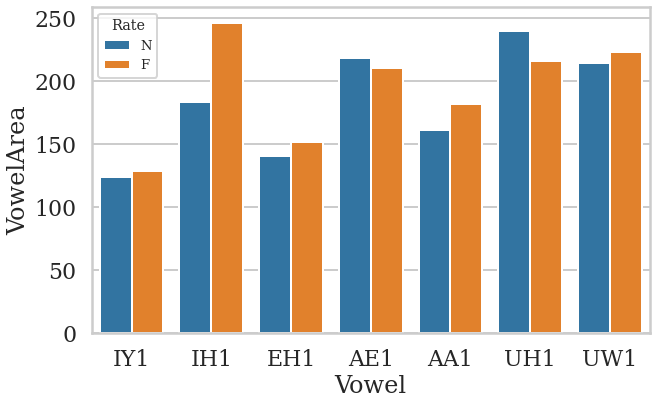

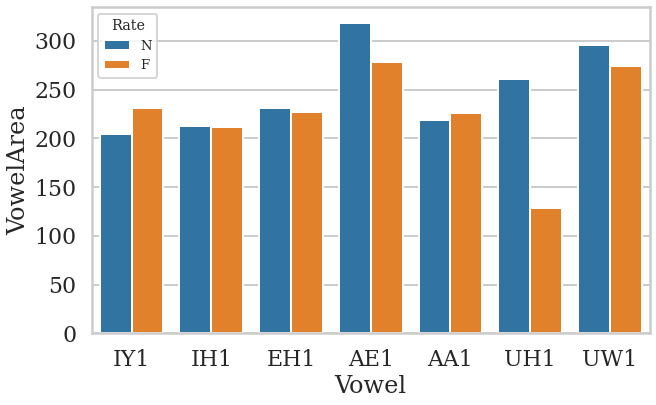

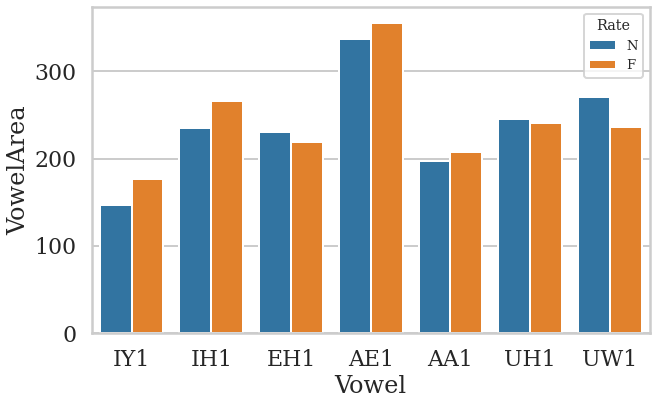

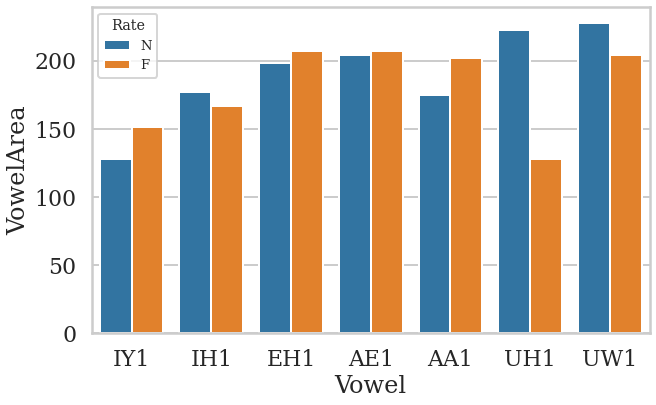

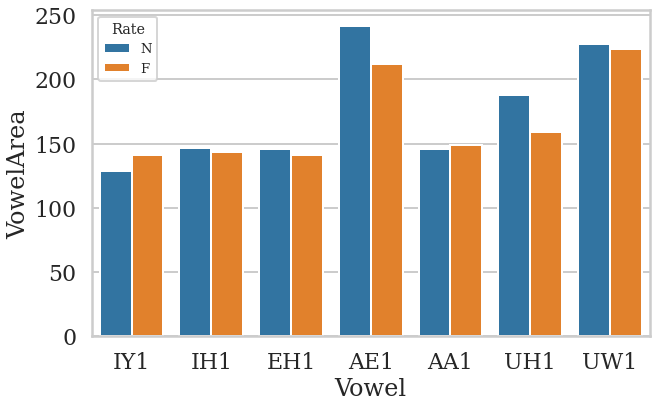

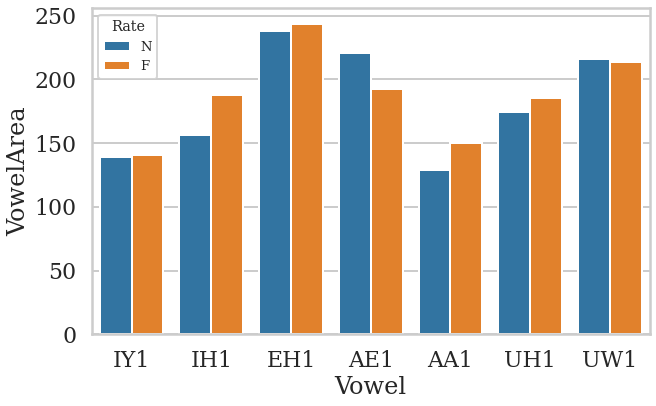

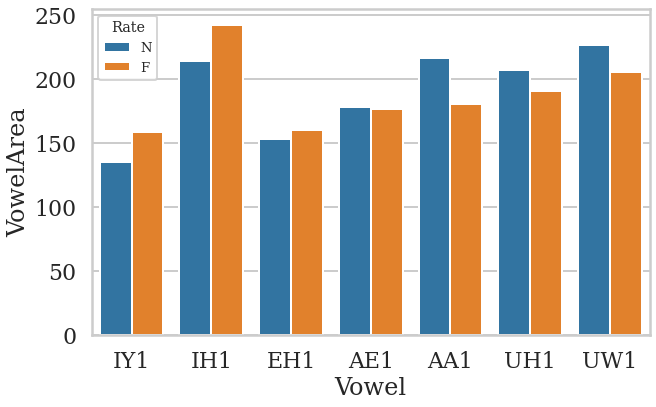

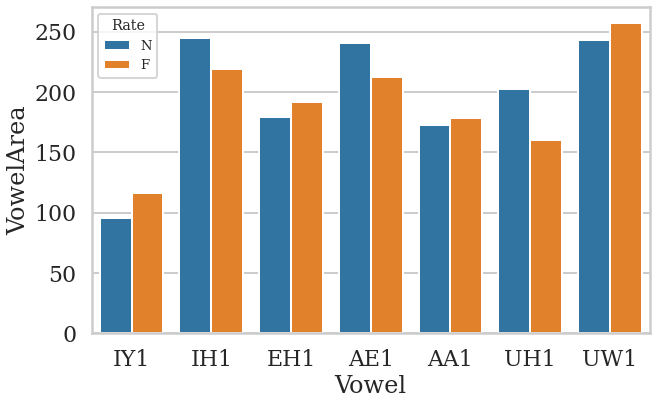

In [13]:
for which_spkr in spkr_list:
    fig, ax = plt.subplots(1, figsize=(10,6), facecolor='white')
    with sns.plotting_context('poster', font_scale=0.6):
        sns.barplot(ax=ax, x='Vowel', y='VowelArea', hue='Rate', data=VA[VA.Speaker==which_spkr])

#### (2) Vowel space areas

In [14]:
# Calculate vowel space area per speaker/rate
def PolyArea(x,y):
    return 0.5*np.abs(np.dot(x,np.roll(y,1))-np.dot(y,np.roll(x,1)))

In [15]:
for which_spkr in spkr_list:
    for which_rate in rate_list:
        
        d = D.loc[(D.Speaker==which_spkr)&(D.Rate==which_rate)&(D.Vowel.isin(custom_vowels)), acous_col]
        xs, ys = d['F1_mel'].values, d['F2_mel'].values
        
        space_area = np.sqrt(PolyArea(xs, ys))
        
        VA.loc[(VA.Speaker==which_spkr)&(VA.Rate==which_rate), ['SpaceArea']] = space_area

In [16]:
VA

,Speaker,Rate,Vowel,VowelArea,SpaceArea
0,F01,N,IY1,124.199089,2587.461259
1,F01,N,IH1,183.367269,2587.461259
2,F01,N,EH1,140.404626,2587.461259
3,F01,N,AE1,218.537815,2587.461259
4,F01,N,AA1,161.722229,2587.461259
...,...,...,...,...,...
107,M04,F,EH1,191.9277,1235.323196
108,M04,F,AE1,212.775521,1235.323196
109,M04,F,AA1,178.695633,1235.323196
110,M04,F,UH1,160.712341,1235.323196


# 화자별로 Vowel space area 넓이를 노멀라이즈해서 비교가 좀 더 수월하게 되도록 만들기 (2021-04-15 목)

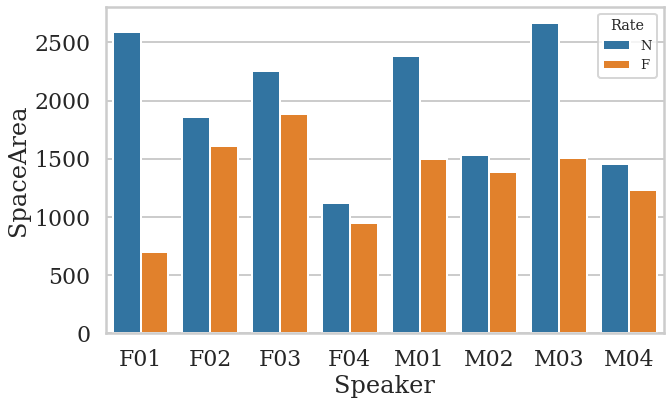

In [17]:
fig, ax = plt.subplots(1, figsize=(10,6), facecolor='white')
with sns.plotting_context('poster', font_scale=0.6):
    sns.barplot(ax=ax, x='Speaker', y='SpaceArea', hue='Rate', data=VA)

---

## Descriptive Analysis
- Speaker X Rate X F1
- Speaker X Rate X F2
- Table summarizing F1, F2 across speaker, rate, context

In [104]:
# Choose vowel mid-point
d = D.loc[D.TimeAt==0.5, ['Speaker','Rate','Vowel','PreVowelPOA']+acous_col].reset_index(drop=True)
print('shape', d.shape)
    
d.head()

shape (27715, 6)


,Speaker,Rate,Vowel,PreVowelPOA,F1_mel,F2_mel
0,F01,F,UW1,alveolar,534.149186,1538.951736
1,F01,F,UW1,bilabial,443.106992,1274.721368
2,F01,N,UW1,alveolar,518.052586,1409.179363
3,F01,N,IH1,lateral,596.959880,1464.224563
4,F01,N,AA1,alveolar,770.610916,1170.500893


In [ ]:
# # palette = sns.color_palette('tab10', len(rate_list))
# palette = sns.color_palette('tab10', len(vowel_list))

# fig, arr = plt.subplots(2, 2, facecolor='white', figsize=(16,8))
# with sns.plotting_context('paper', font_scale=1.2):
#     # (1,1)
#     sns.boxplot(ax=arr[0,0], data=d.loc[d.Rate=='N'], 
#                 x='Speaker', y='F1_mel', hue='Vowel', hue_order=vowel_list, 
#                 #palette=['blue','red'], 
#                 palette=palette)
#     #ax1.set_ylim([200, 1300])
#     arr[0,0].invert_yaxis()
    
#     # (1,2)
#     sns.boxplot(ax=arr[0,1], data=d.loc[d.Rate=='F'], 
#                 x='Speaker', y='F1_mel', hue='Vowel', hue_order=vowel_list, 
#                 #palette=['blue','red'], 
#                 palette=palette)
#     #ax2.set_ylim([600, 2000])
#     arr[0,1].invert_yaxis()
    
# fig.tight_layout()

---

## Inferential Statistics on F1 and F2
- See: `Articulatory-Data-Processor/_1-03_stat_acous.ipynb`

In [16]:
%load_ext rpy2.ipython

In [18]:
%%R
# Stat
library(car)
library(stats)
library(lme4)
library(emmeans)

# Plotting
library(ggplot2)
library(ggeffects)
library(ggpubr)
library(sjPlot)

## COV: coefficients of variation

In [135]:
d = D[['Speaker','Vowel','PreVowelPOA','Rate','F1_mel','F2_mel']].reset_index(drop=True)
d = (d.groupby(['Speaker','Vowel','PreVowelPOA','Rate'])
     .agg(['mean','std'])
     .reset_index()
    )

d['F1_CV'] = d['F1_mel']['std']/d['F1_mel']['mean'] * 100
d['F2_CV'] = d['F2_mel']['std']/d['F2_mel']['mean'] * 100
d = d[['Speaker','Vowel','PreVowelPOA','Rate','F1_CV','F2_CV']].reset_index(drop=True)
d.columns = ['Speaker','Vowel','PreVowelPOA','Rate','F1_CV','F2_CV']

In [141]:
%%R -i d
d$Rate = as.factor(d$Rate)
d$Vowel = as.factor(d$Vowel)
d$Speaker = as.factor(d$Speaker)
d$PreVowelPOA = as.factor(d$PreVowelPOA)

d$Vowel <- ordered(d$Vowel, levels = c("IY1", "IH1", "EH1", "AE1", "AA1", "AH1", "AO1", "UW1"))
d$PreVowelPOA = ordered(d$PreVowelPOA, levels=c("bilabial","alveolar","velar","pharyngeal"))

cov.F1 = lmer(F1_CV ~ Rate*PreVowelPOA*Vowel + (1|Speaker), data=d)
# summary(cov.F1)
Anova(cov.F1, type=3)

Analysis of Deviance Table (Type III Wald chisquare tests)

Response: F1_CV
                         Chisq Df Pr(>Chisq)    
(Intercept)            270.142  1  < 2.2e-16 ***
Rate                    12.735  1  0.0003588 ***
PreVowelPOA             27.626  3  4.351e-06 ***
Vowel                  113.657  7  < 2.2e-16 ***
Rate:PreVowelPOA         0.251  3  0.9689618    
Rate:Vowel              13.249  7  0.0662760 .  
PreVowelPOA:Vowel      108.433 21  9.029e-14 ***
Rate:PreVowelPOA:Vowel  10.784 21  0.9668249    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


In [142]:
%%R
cov.F2 = lmer(F2_CV ~ Rate*PreVowelPOA*Vowel + (1|Speaker), data=d)
# summary(cov.F1)
Anova(cov.F2, type=3)

Analysis of Deviance Table (Type III Wald chisquare tests)

Response: F2_CV
                          Chisq Df Pr(>Chisq)    
(Intercept)            430.3844  1  < 2.2e-16 ***
Rate                    18.1737  1  2.016e-05 ***
PreVowelPOA              0.4596  3     0.9277    
Vowel                  162.2267  7  < 2.2e-16 ***
Rate:PreVowelPOA         1.1962  3     0.7539    
Rate:Vowel              53.8017  7  2.574e-09 ***
PreVowelPOA:Vowel       20.3344 21     0.5002    
Rate:PreVowelPOA:Vowel  11.4659 21     0.9529    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


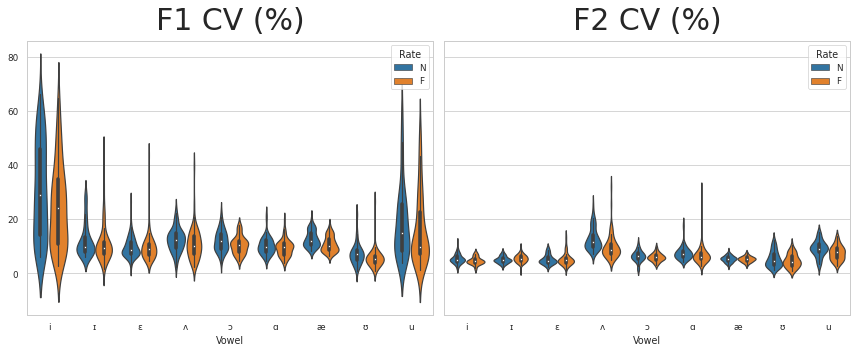

In [143]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,5), facecolor='white', sharey=True)

with sns.plotting_context('paper'):
    sns.violinplot(ax=ax1, x='Vowel', y='F1_CV', hue='Rate', 
                   order=vowel_list, hue_order=['N','F'], data=d)
    sns.violinplot(ax=ax2, x='Vowel', y='F2_CV', hue='Rate', 
                   order=vowel_list, hue_order=['N','F'], data=d)
    
    ax1.set_title('F1 CV (%)', fontsize=30, y=1.02)
    ax2.set_title('F2 CV (%)', fontsize=30, y=1.02)
    ax1.set_ylabel('')
    ax2.set_ylabel('')
    ax1.set_xticklabels([vowel2ipa[v] for v in vowel_list])
    ax2.set_xticklabels([vowel2ipa[v] for v in vowel_list])
    fig.tight_layout()

## LME model when DV:F1

In [14]:
d = D.loc[D.Vowel.isin(['IY1','IH1','EH1','AE1'])].reset_index(drop=True)

In [19]:
%%R -i d
d$Rate = as.factor(d$Rate)
d$Vowel = as.factor(d$Vowel)
d$PreVowel = as.factor(d$PreVowel)
d$Speaker = as.factor(d$Speaker)
d$Block = as.factor(d$Block)
d$Token = as.factor(d$Token)
d$PreVowelPOA = as.factor(d$PreVowelPOA)
d$PostVowelPOA = as.factor(d$PostVowelPOA)

d$Vowel <- ordered(d$Vowel, levels = c("IY1", "IH1", "EH1", "AE1"))
d$PreVowelPOA = ordered(d$PreVowelPOA, levels=c("bilabial","alveolar","velar","pharyngeal"))

In [21]:
%%R
m.F1 = lmer(F1_norm ~ Rate*PreVowelPOA*Vowel + (1|Speaker), data=d)
summary(m.F1)

Linear mixed model fit by REML ['lmerMod']
Formula: F1_norm ~ Rate * PreVowelPOA * Vowel + (1 | Speaker)
   Data: d

REML criterion at convergence: 70274.4

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-4.4236 -0.4909 -0.0750  0.3561 11.8095 

Random effects:
 Groups   Name        Variance Std.Dev.
 Speaker  (Intercept) 0.003088 0.05557 
 Residual             0.266905 0.51663 
Number of obs: 46175, groups:  Speaker, 8

Fixed effects:
                             Estimate Std. Error t value
(Intercept)                  0.025663   0.020377   1.259
RateN                        0.041298   0.007034   5.871
PreVowelPOA.L               -0.013826   0.010332  -1.338
PreVowelPOA.Q                0.038678   0.010793   3.584
PreVowelPOA.C                0.041332   0.011231   3.680
Vowel.L                      1.036018   0.011427  90.667
Vowel.Q                     -0.007147   0.010795  -0.662
Vowel.C                     -0.074545   0.010120  -7.366
RateN:PreVowelPOA.L         -0.006

R[write to console]: 
Correlation matrix not shown by default, as p = 32 > 12.
Use print(object, correlation=TRUE)  or
    vcov(object)        if you need it




In [22]:
%%R
# emm_options(pbkrtest.limit = 89315)
em.F1 = emmeans(m.F1, ~ Rate|Vowel, adjust = "tukey")
pairs(em.F1)

R[write to console]: Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'pbkrtest.limit = 46175' (or larger)
[or, globally, 'set emm_options(pbkrtest.limit = 46175)' or larger];
but be warned that this may result in large computation time and memory use.

R[write to console]: Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'lmerTest.limit = 46175' (or larger)
[or, globally, 'set emm_options(lmerTest.limit = 46175)' or larger];
but be warned that this may result in large computation time and memory use.

R[write to console]: NOTE: Results may be misleading due to involvement in interactions



Vowel = IY1:
 contrast estimate     SE  df z.ratio p.value
 F - N     -0.0040 0.0187 Inf -0.214  0.8303 

Vowel = IH1:
 contrast estimate     SE  df z.ratio p.value
 F - N     -0.0186 0.0116 Inf -1.610  0.1075 

Vowel = EH1:
 contrast estimate     SE  df z.ratio p.value
 F - N     -0.0785 0.0141 Inf -5.568  <.0001 

Vowel = AE1:
 contrast estimate     SE  df z.ratio p.value
 F - N     -0.0641 0.0105 Inf -6.092  <.0001 

Results are averaged over the levels of: PreVowelPOA 
Degrees-of-freedom method: asymptotic 


In [23]:
%%R
em.F1.poa = emmeans(m.F1, ~ Rate|PreVowelPOA|Vowel, adjust = "tukey")
pairs(em.F1.poa)

R[write to console]: Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'pbkrtest.limit = 46175' (or larger)
[or, globally, 'set emm_options(pbkrtest.limit = 46175)' or larger];
but be warned that this may result in large computation time and memory use.

R[write to console]: Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'lmerTest.limit = 46175' (or larger)
[or, globally, 'set emm_options(lmerTest.limit = 46175)' or larger];
but be warned that this may result in large computation time and memory use.



PreVowelPOA = bilabial, Vowel = IY1:
 contrast estimate     SE  df z.ratio p.value
 F - N     0.00773 0.0203 Inf  0.381  0.7034 

PreVowelPOA = alveolar, Vowel = IY1:
 contrast estimate     SE  df z.ratio p.value
 F - N    -0.05347 0.0146 Inf -3.659  0.0003 

PreVowelPOA = velar, Vowel = IY1:
 contrast estimate     SE  df z.ratio p.value
 F - N     0.01631 0.0653 Inf  0.250  0.8029 

PreVowelPOA = pharyngeal, Vowel = IY1:
 contrast estimate     SE  df z.ratio p.value
 F - N     0.01343 0.0260 Inf  0.516  0.6057 

PreVowelPOA = bilabial, Vowel = IH1:
 contrast estimate     SE  df z.ratio p.value
 F - N    -0.04134 0.0212 Inf -1.952  0.0509 

PreVowelPOA = alveolar, Vowel = IH1:
 contrast estimate     SE  df z.ratio p.value
 F - N     0.00626 0.0150 Inf  0.418  0.6758 

PreVowelPOA = velar, Vowel = IH1:
 contrast estimate     SE  df z.ratio p.value
 F - N    -0.07621 0.0230 Inf -3.313  0.0009 

PreVowelPOA = pharyngeal, Vowel = IH1:
 contrast estimate     SE  df z.ratio p.value
 F - N   

In [ ]:
# %%R
# par(family  = "Arial")
# install.packages("showtext")
# library(showtext)
# showtext_auto()


R[write to console]: Note: adjust = "tukey" was changed to "sidak"
because "tukey" is only appropriate for one set of pairwise comparisons



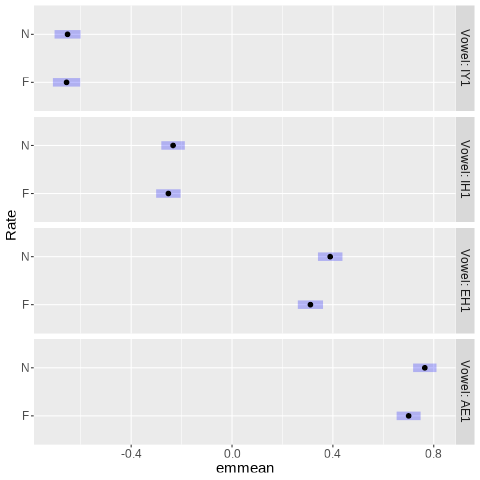

In [27]:
%%R
cex <- 1.7
par(cex.lab=cex, cex.axis=cex, cex.main=cex)
plot(em.F1, by = "Vowel", intervals = TRUE, type = "response")

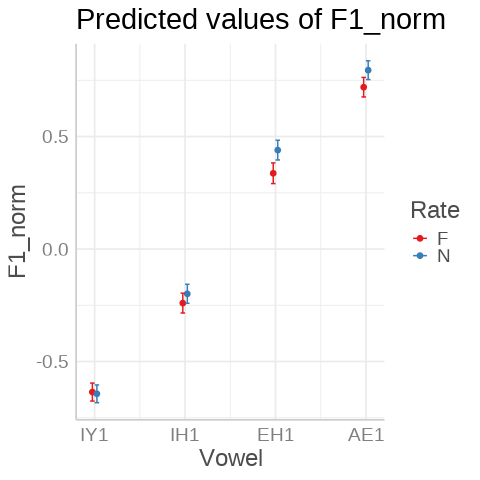

In [29]:
%%R
plot_model(m.F1, type='pred', terms=c("Vowel","Rate"), 
           show.values = TRUE, show.p = TRUE, p.shape = TRUE) +
    theme_sjplot(base_size = 18, base_family = "")

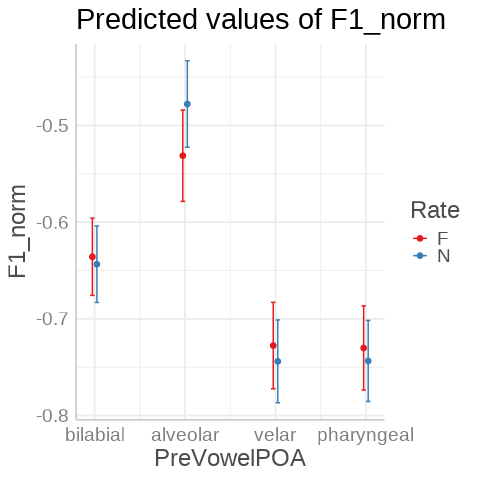

In [30]:
%%R
plot_model(m.F1, type = "pred", terms = c("PreVowelPOA", "Rate"), show.values = TRUE) +
    theme_sjplot(base_size = 18, base_family = "")

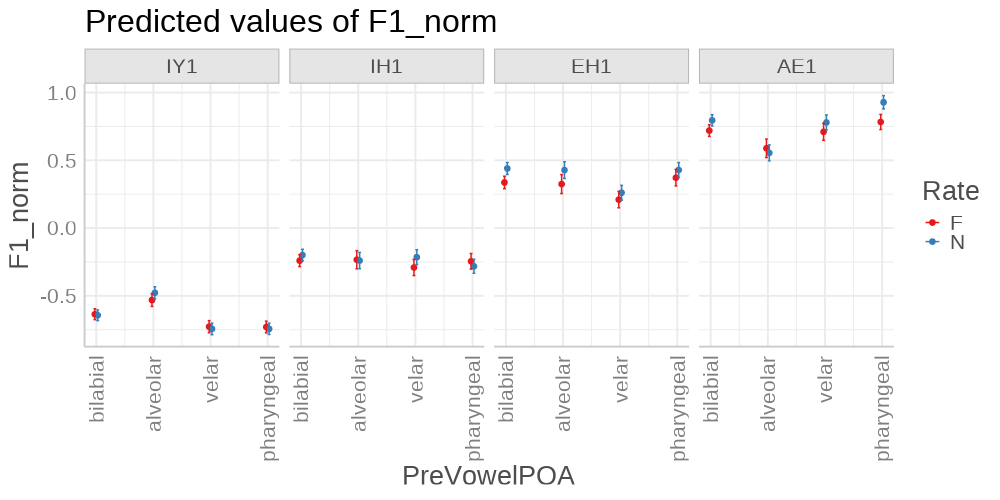

In [42]:
%%R -w 1000 -h 500
plot_model(m.F1, type = "pred", terms = c("PreVowelPOA", "Rate", "Vowel"), show.values = TRUE) +
    facet_wrap(~facet, ncol = 8) +
    theme_sjplot(base_size = 20, base_family = "") +
    theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1))

### LME model when DV:F2

In [34]:
%%R
m.F2 = lmer(F2_norm ~ Rate*PreVowelPOA*Vowel + (1|Speaker), data=d)
summary(m.F2)

Linear mixed model fit by REML ['lmerMod']
Formula: F2_norm ~ Rate * PreVowelPOA * Vowel + (1 | Speaker)
   Data: d

REML criterion at convergence: 43950.4

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-6.2143 -0.6221 -0.0590  0.5738  5.1818 

Random effects:
 Groups   Name        Variance Std.Dev.
 Speaker  (Intercept) 0.001301 0.03607 
 Residual             0.150874 0.38843 
Number of obs: 46175, groups:  Speaker, 8

Fixed effects:
                             Estimate Std. Error  t value
(Intercept)                  0.396954   0.013384   29.659
RateN                        0.094434   0.005288   17.857
PreVowelPOA.L                0.008926   0.007768    1.149
PreVowelPOA.Q               -0.048891   0.008114   -6.025
PreVowelPOA.C               -0.043847   0.008444   -5.193
Vowel.L                     -0.859632   0.008591 -100.061
Vowel.Q                      0.241063   0.008116   29.701
Vowel.C                      0.109402   0.007609   14.378
RateN:PreVowelPOA.L      

R[write to console]: 
Correlation matrix not shown by default, as p = 32 > 12.
Use print(object, correlation=TRUE)  or
    vcov(object)        if you need it




In [35]:
%%R
# Use anova to assess whether the factor as a whole is explanatory
Anova(m.F2, type=3)

Analysis of Deviance Table (Type III Wald chisquare tests)

Response: F2_norm
                           Chisq Df Pr(>Chisq)    
(Intercept)              879.681  1  < 2.2e-16 ***
Rate                     318.873  1  < 2.2e-16 ***
PreVowelPOA               42.878  3  2.612e-09 ***
Vowel                  10666.400  3  < 2.2e-16 ***
Rate:PreVowelPOA          21.186  3  9.634e-05 ***
Rate:Vowel               171.696  3  < 2.2e-16 ***
PreVowelPOA:Vowel        117.997  9  < 2.2e-16 ***
Rate:PreVowelPOA:Vowel    41.492  9  4.069e-06 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


In [36]:
%%R
em.F2 = emmeans(m.F2, ~ Rate|Vowel, adjust = "tukey")
pairs(em.F2)

R[write to console]: Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'pbkrtest.limit = 46175' (or larger)
[or, globally, 'set emm_options(pbkrtest.limit = 46175)' or larger];
but be warned that this may result in large computation time and memory use.

R[write to console]: Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'lmerTest.limit = 46175' (or larger)
[or, globally, 'set emm_options(lmerTest.limit = 46175)' or larger];
but be warned that this may result in large computation time and memory use.

R[write to console]: NOTE: Results may be misleading due to involvement in interactions



Vowel = IY1:
 contrast estimate      SE  df z.ratio p.value
 F - N     -0.1602 0.01403 Inf -11.420 <.0001 

Vowel = IH1:
 contrast estimate      SE  df z.ratio p.value
 F - N     -0.0122 0.00869 Inf  -1.408 0.1593 

Vowel = EH1:
 contrast estimate      SE  df z.ratio p.value
 F - N     -0.1618 0.01059 Inf -15.270 <.0001 

Vowel = AE1:
 contrast estimate      SE  df z.ratio p.value
 F - N     -0.0435 0.00792 Inf  -5.499 <.0001 

Results are averaged over the levels of: PreVowelPOA 
Degrees-of-freedom method: asymptotic 


In [37]:
%%R
em.F2.poa = emmeans(m.F2, ~ Rate|PreVowelPOA|Vowel, adjust = "tukey")
pairs(em.F2.poa)

R[write to console]: Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'pbkrtest.limit = 46175' (or larger)
[or, globally, 'set emm_options(pbkrtest.limit = 46175)' or larger];
but be warned that this may result in large computation time and memory use.

R[write to console]: Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'lmerTest.limit = 46175' (or larger)
[or, globally, 'set emm_options(lmerTest.limit = 46175)' or larger];
but be warned that this may result in large computation time and memory use.



PreVowelPOA = bilabial, Vowel = IY1:
 contrast estimate     SE  df z.ratio p.value
 F - N     -0.1172 0.0153 Inf  -7.685 <.0001 

PreVowelPOA = alveolar, Vowel = IY1:
 contrast estimate     SE  df z.ratio p.value
 F - N     -0.1638 0.0110 Inf -14.912 <.0001 

PreVowelPOA = velar, Vowel = IY1:
 contrast estimate     SE  df z.ratio p.value
 F - N     -0.2084 0.0491 Inf  -4.242 <.0001 

PreVowelPOA = pharyngeal, Vowel = IY1:
 contrast estimate     SE  df z.ratio p.value
 F - N     -0.1515 0.0196 Inf  -7.741 <.0001 

PreVowelPOA = bilabial, Vowel = IH1:
 contrast estimate     SE  df z.ratio p.value
 F - N      0.0176 0.0159 Inf   1.103 0.2702 

PreVowelPOA = alveolar, Vowel = IH1:
 contrast estimate     SE  df z.ratio p.value
 F - N     -0.0155 0.0113 Inf  -1.377 0.1685 

PreVowelPOA = velar, Vowel = IH1:
 contrast estimate     SE  df z.ratio p.value
 F - N     -0.0634 0.0173 Inf  -3.666 0.0002 

PreVowelPOA = pharyngeal, Vowel = IH1:
 contrast estimate     SE  df z.ratio p.value
 F - N   

R[write to console]: Note: adjust = "tukey" was changed to "sidak"
because "tukey" is only appropriate for one set of pairwise comparisons



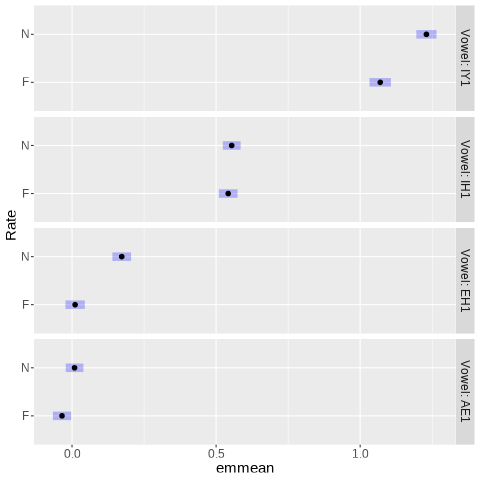

In [38]:
%%R
plot(em.F2, by = "Vowel", intervals = TRUE, type = "response")

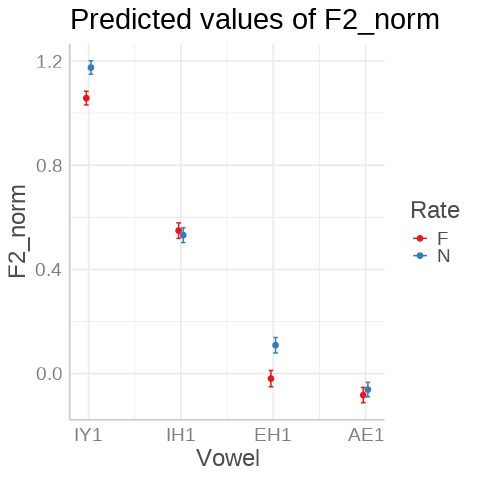

In [39]:
%%R
plot_model(m.F2, type='pred', terms=c("Vowel","Rate")) +
    theme_sjplot(base_size = 18, base_family = "")

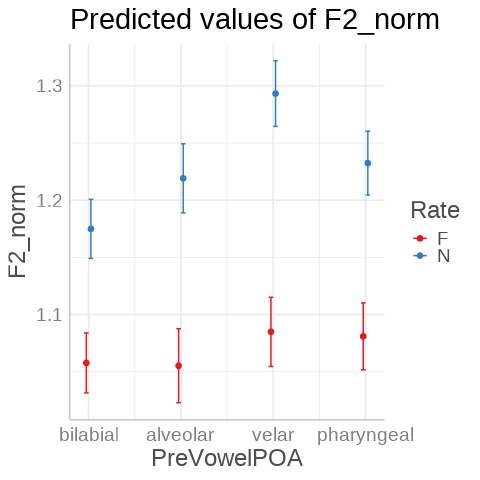

In [40]:
%%R
plot_model(m.F2, type = "pred", terms = c("PreVowelPOA", "Rate")) +
    theme_sjplot(base_size = 18, base_family = "")

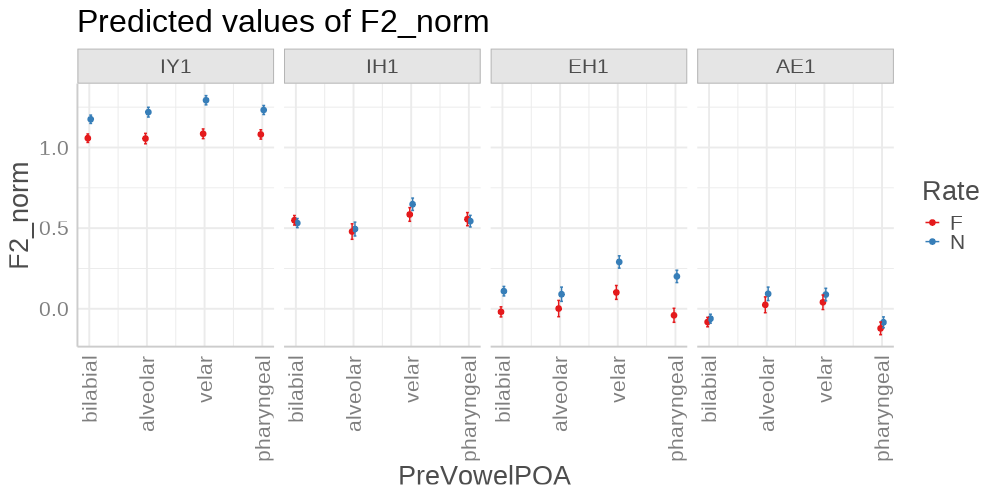

In [41]:
%%R -w 1000 -h 500
plot_model(m.F2, type = "pred", terms = c("PreVowelPOA", "Rate", "Vowel"), show.values = TRUE) +
    facet_wrap(~facet, ncol = 8) +
    theme_sjplot(base_size = 20, base_family = "") +
    theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1))